In [1]:
# reference: https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

Number of qubits: 2


In [4]:
%%time

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(H2_op))
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728
CPU times: user 645 ms, sys: 291 ms, total: 936 ms
Wall time: 832 ms


In [5]:
# define ansatz and optimizer
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

In [6]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [7]:
# define Aer Estimator for noiseless statevector simulation
from qiskit.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [8]:
%%time
# instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE

vqe_spsa = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)
result_spsa = vqe_spsa.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result_spsa.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_spsa.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.84322
Delta from reference energy value is 0.01406
CPU times: user 12.4 s, sys: 194 ms, total: 12.6 s
Wall time: 12.8 s


Text(0.5, 1.0, 'Convergence with no noise')

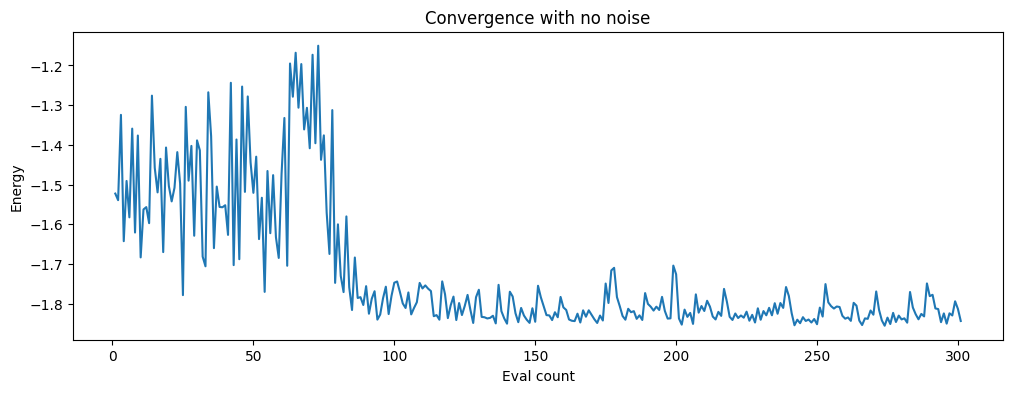

In [9]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

### with powell

In [10]:
# re-start callback variables
counts = []
values = []

In [11]:
%%time

# instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import POWELL

iterations = 125
powell = POWELL(maxiter=iterations)

vqe_powell = VQE(
    noiseless_estimator, ansatz, optimizer=powell, callback=store_intermediate_result
)
result_powell = vqe_powell.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result_powell.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_powell.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.84778
Delta from reference energy value is 0.00950
CPU times: user 19.6 s, sys: 394 ms, total: 20 s
Wall time: 20.2 s


Text(0.5, 1.0, 'Convergence with no noise and use of powell')

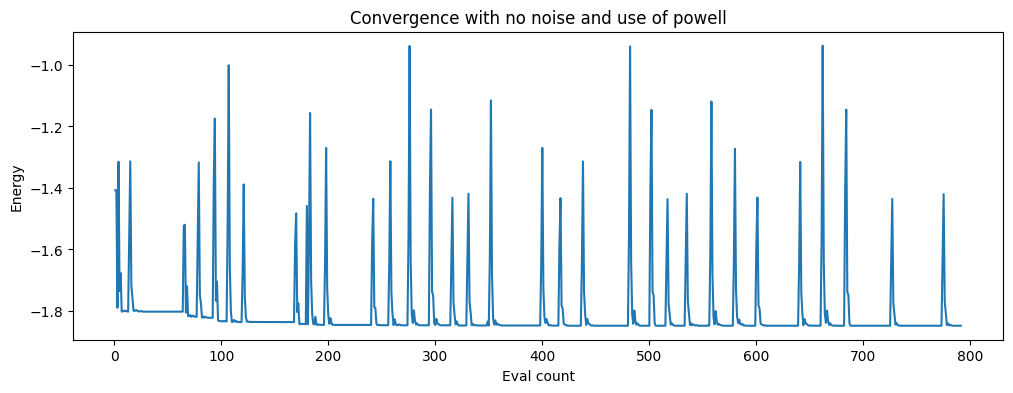

In [12]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise and use of powell")

### With noise and powell

In [13]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit Terra,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'id', 'cx', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [14]:
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [15]:
# re-start callback variables
counts = []
values = []

In [17]:
%%time

vqe_spsa.estimator = noisy_estimator

result_spsa_noise = vqe_spsa.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result_spsa_noise.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_spsa_noise.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (with noise): -1.75964
Delta from reference energy value is 0.09763
CPU times: user 53.3 s, sys: 485 ms, total: 53.8 s
Wall time: 43.9 s


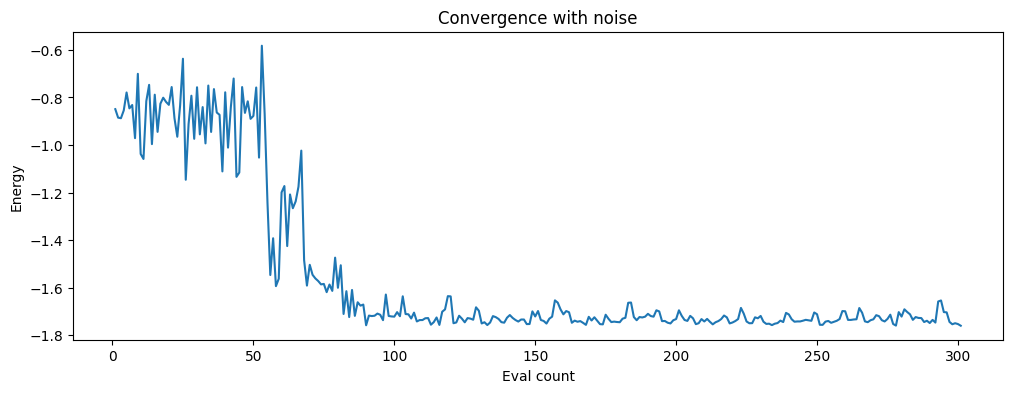

In [18]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

In [19]:
# re-start callback variables
counts = []
values = []

In [20]:
%%time

vqe_powell.estimator = noisy_estimator

result_powell_noise = vqe_powell.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result_powell_noise.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_powell_noise.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (with noise): -1.73263
Delta from reference energy value is 0.12465
CPU times: user 3min 6s, sys: 1.77 s, total: 3min 8s
Wall time: 1min 50s


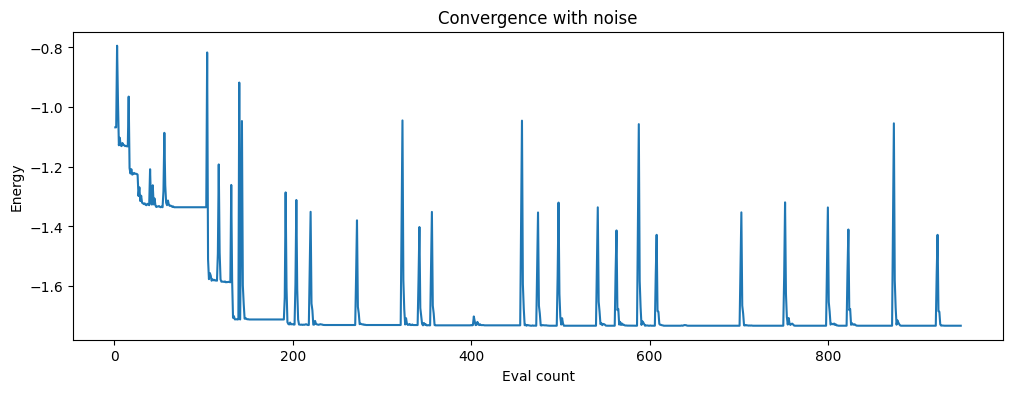

In [21]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

# nelder mead

In [22]:
# re-start callback variables
counts = []
values = []

In [23]:
%%time

#instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import NELDER_MEAD

iterations = 125
nelder= NELDER_MEAD(maxiter=iterations)

vqe_nelder= VQE(
    noiseless_estimator, ansatz, optimizer=nelder, callback=store_intermediate_result
)
result_nelder= vqe_nelder.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result_nelder.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_nelder.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.84698
Delta from reference energy value is 0.01029
CPU times: user 5 s, sys: 133 ms, total: 5.13 s
Wall time: 5.33 s


Text(0.5, 1.0, 'Convergence with no noise and use of nelder-mead')

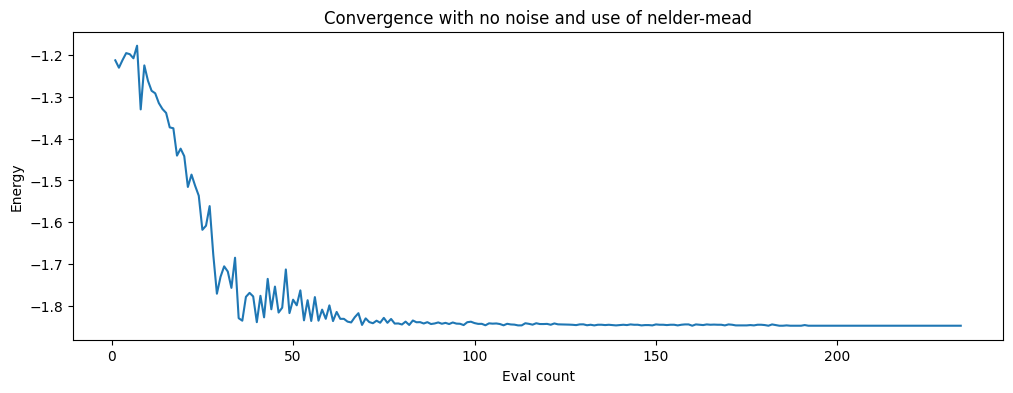

In [24]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise and use of nelder-mead")

In [25]:
# re-start callback variables
counts = []
values = []

In [26]:
%%time

vqe_nelder.estimator = noisy_estimator

result_nelder_noise = vqe_nelder.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result_nelder_noise.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_nelder_noise.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (with noise): -1.73403
Delta from reference energy value is 0.12325
CPU times: user 47.4 s, sys: 485 ms, total: 47.9 s
Wall time: 29.2 s


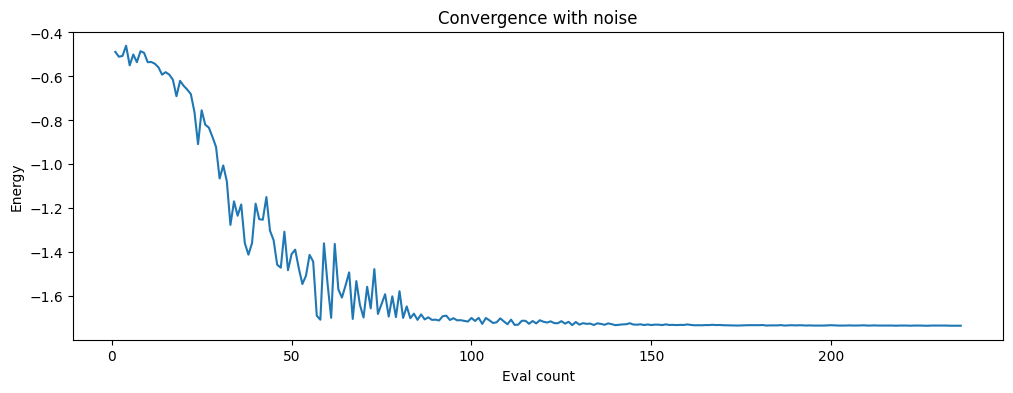

In [27]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

# QNSPSA

In [28]:
# re-start callback variables
counts = []
values = []

In [29]:
%%time

# instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.primitives import Sampler

iterations = 125

#fidelity
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(ansatz, sampler)

qnspsa = QNSPSA(fidelity, maxiter=iterations)

vqe_qnspsa = VQE(
    noiseless_estimator, ansatz, optimizer=qnspsa, callback=store_intermediate_result
)
result_qnspsa= vqe_qnspsa.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result_qnspsa.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_qnspsa.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.83759
Delta from reference energy value is 0.01969
CPU times: user 25.4 s, sys: 821 ms, total: 26.2 s
Wall time: 25.8 s


Text(0.5, 1.0, 'Convergence with no noise and use of qnspsa')

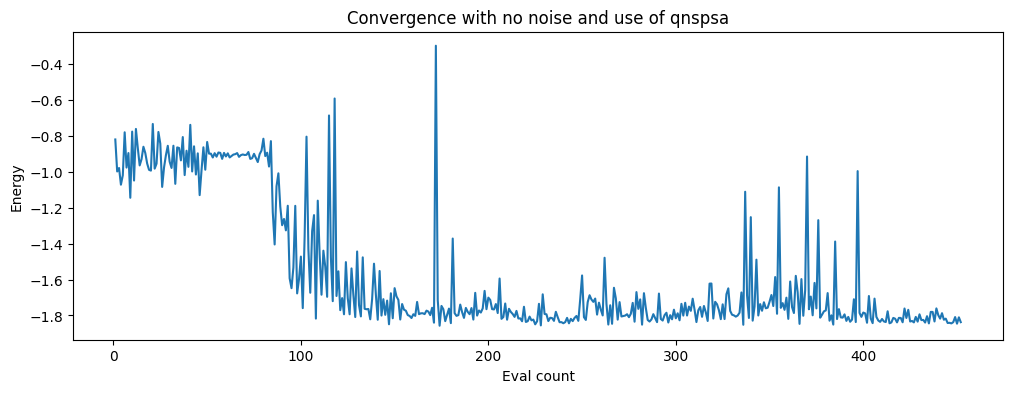

In [31]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise and use of qnspsa")

In [32]:
# re-start callback variables
counts = []
values = []

In [33]:
%%time

vqe_qnspsa.estimator = noisy_estimator

result_qnspsa_noise = vqe_qnspsa.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result_qnspsa_noise.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result_qnspsa_noise.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (with noise): -1.74421
Delta from reference energy value is 0.11306
CPU times: user 1min 12s, sys: 765 ms, total: 1min 13s
Wall time: 53.2 s


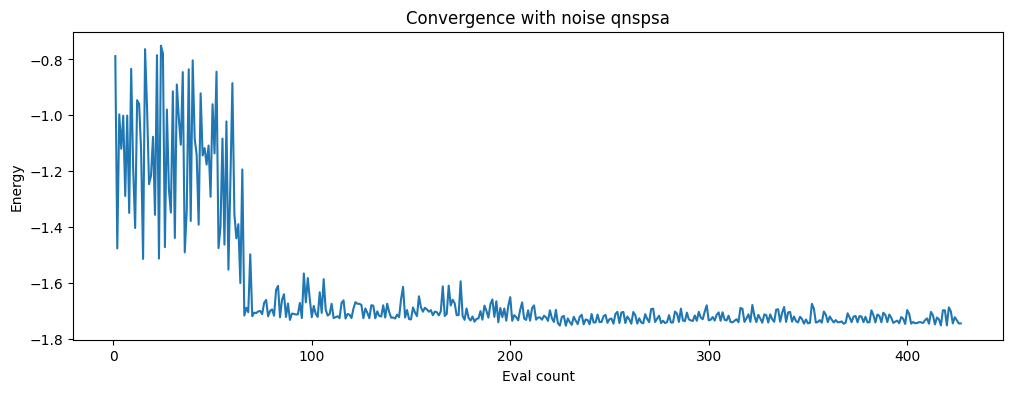

In [34]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise qnspsa")

### Summary

In [35]:
print(f"Reference value: {ref_value:.5f}")
print("Results with without noise:")
print(f"\tVQE SPSA on Aer qasm simulator: {result_spsa.eigenvalue.real:.5f}")
print(f"\tVQE POWELL on Aer qasm simulator: {result_powell.eigenvalue.real:.5f}")
print(f"\tVQE NELDER on Aer qasm simulator: {result_nelder.eigenvalue.real:.5f}")
print(f"\tVQE QNSPSA on Aer qasm simulator: {result_qnspsa.eigenvalue.real:.5f}")
print("Results with noise:")
print(f"\tVQE SPSA on Aer qasm simulator: {result_spsa_noise.eigenvalue.real:.5f}")
print(f"\tVQE POWELL on Aer qasm simulator: {result_powell_noise.eigenvalue.real:.5f}")
print(f"\tVQE NELDER on Aer qasm simulator: {result_nelder_noise.eigenvalue.real:.5f}")
print(f"\tVQE QNSPSA on Aer qasm simulator: {result_qnspsa_noise.eigenvalue.real:.5f}")
print("Cost evals needed with noise:")
print(f"\tFunction evaluations SPSA: {result_spsa_noise.cost_function_evals}")
print(f"\tFunction evaluations POWELL: {result_powell_noise.cost_function_evals}")
print(f"\tFunction evaluations NELDER: {result_nelder_noise.cost_function_evals}")
print(f"\tFunction evaluations QNSPSA: {result_qnspsa_noise.cost_function_evals}")

Reference value: -1.85728
Results with without noise:
	VQE SPSA on Aer qasm simulator: -1.84322
	VQE POWELL on Aer qasm simulator: -1.84778
	VQE NELDER on Aer qasm simulator: -1.84698
	VQE QNSPSA on Aer qasm simulator: -1.83759
Results with noise:
	VQE SPSA on Aer qasm simulator: -1.75964
	VQE POWELL on Aer qasm simulator: -1.73263
	VQE NELDER on Aer qasm simulator: -1.73403
	VQE QNSPSA on Aer qasm simulator: -1.74421
Cost evals needed with noise:
	Function evaluations SPSA: 250
	Function evaluations POWELL: 949
	Function evaluations NELDER: 236
	Function evaluations QNSPSA: 876


In [36]:
print("WALL exact solution: 832ms")
print("WALL SPSA-noise solution: 43.9s")
print("WALL POWELL-noise solution: 1min 50s")
print("WALL NELDER solution: 29.2 s")
print("WALL QNSPSA solution: 53.2 s")

WALL exact solution: 832ms
WALL SPSA-noise solution: 43.9s
WALL POWELL-noise solution: 1min 50s
WALL NELDER solution: 29.2 s
WALL QNSPSA solution: 53.2 s


In [37]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright